In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("latest-post-travel-categories.xlsx")
df.head()

,Title,Content,Author,Publish Date,Cateogry
0,"What to do at National Textiles Museum, Kuala ...","Located within one of Kuala Lumpur’s <a href=""...",CHESTER CHIN,2019-04-04 06:00:04,Malaysia
1,The appeal of the overnight train in Austria,It looks like a scene from the halcyon days of...,AGENCY,2019-04-03 06:00:02,Europe
2,Rare exhibition of Edvard Munch’s prints to op...,The British Museum will host the largest exhib...,AGENCY,2019-04-02 07:00:33,Europe
3,Why it's cool to surf in Russia during winter,"Russian winter surfing fan Konstantin Sankov, ...",AGENCY,2019-04-01 06:00:50,Europe
4,Bringing your pooch on a plane? Here’s what yo...,"Sometimes, a travel destination is not reachab...",AGENCY,2019-04-01 06:00:08,Travel


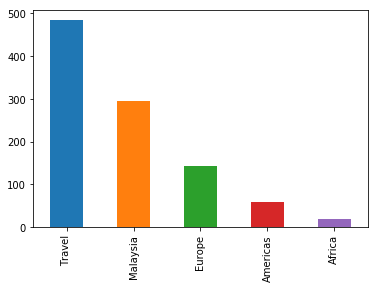

In [9]:
df['Cateogry'].value_counts().plot.bar()

# Text Process Tools & Utility Function

In [11]:
import gensim
import spacy

nlp = spacy.load('en_core_web_sm')

In [218]:
from gensim.parsing.preprocessing import strip_tags, strip_numeric
from nltk.corpus import stopwords
import string
import re

STOPWORDS = set(stopwords.words('english')).union({'-PRON-'})  
whitelist = ["not", "no"]
RE_PUNCT = re.compile(r'([%s])+' % re.escape(string.punctuation))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
COMMA_IN_NUMBER = re.compile('(?<=\d),(?=\d)') #There is numbers in front of a comma
STRIP_SYMBOLS =re.compile('(^[^0-9a-zA-Z ])|([^0-9a-zA-Z]$)')

def remove_contract(phrase):
    phrase = phrase.replace("won’t", "")\
                    .replace("can’t", "")\
                    .replace("’re", "")\
                    .replace("’s", "")\
                    .replace("’d", "")\
                    .replace("’ll", "")\
                    .replace("’ve", "")\
                    .replace("’m", "")\
                    .replace("’t","")
    return phrase

def remove_stopwods(text):
    text = text.split()
    text = [t for t in text if t not in STOPWORDS and t or t in whitelist]# delete stopwords from text
    text = ' '.join(text)
    return text

def full_cleaning(text):
    text = remove_contract(text)
    text = text.lower()# lowercase text
    text = RE_PUNCT.sub(' ', text)
    text = COMMA_IN_NUMBER.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = remove_stopwods(text)
    text = strip_numeric(text)
    text = STRIP_SYMBOLS.sub('',text)
    return text.strip('.').strip()

## Entity Extraction using SpaCy 
text with minimum preprocessing required

In [563]:
REMOVE_MORE_TAGS = re.compile("\[.*?=.*?\]")
REMOVE_WEBSITES = re.compile('\w+\.com.*?\s|\w+\.com.*?|www\..*?\s|http(.*?)\s|http(.+)$')
# REMOVE_MONEY = re.compile() ###RM, Rupiah
# REMOVE_DATE = re.compile() ###

def dedup_list(inlist):
    outlist = []
    for i in inlist:
        if i not in outlist:
            outlist.append(i)
    return outlist

def cleaning(text):
    text = strip_tags(text)
    text = text.replace('\t',' ').replace('\n',' ').replace('\xa0','')
    text = text.replace('[/caption]','')
    text = REMOVE_MORE_TAGS.sub(' ', text)
    text = REMOVE_WEBSITES.sub(' ', text)
    text = text.replace('  ',' ')
    return text

def spacy_extract(text):
    nlptext = nlp(text) 
    entities = dedup_list([(i.text,i.label_) for i in nlptext.ents])
    x={}
    x['entity'] = [(i[0].strip(), i[1]) for i in entities if i[0].strip()]
    x['tag'] = [(i.text, i.tag_) for i in nlptext ]
    return x

df['preprocess_text'] = df['Content'].map(cleaning)
df['entity_tag'] = df['preprocess_text'].map(spacy_extract)
df['Entities'] = df['entity_tag'].map(lambda x: x.get('entity',[]))
df['Tags'] = df['entity_tag'].map(lambda x: x.get('tag', []))

In [587]:
df.iloc[0]['Entities'][:20]

[('Kuala Lumpur’s', 'GPE'),
 ('the National Textiles Museum', 'ORG'),
 ('Jalan Sultan', 'PERSON'),
 ('Hishamuddin', 'PERSON'),
 ('1905', 'DATE'),
 ('the Federated Malay States Railway Station', 'LAW'),
 ('Selangor Works Department', 'PERSON'),
 ('Today', 'DATE'),
 ('Malaysia', 'GPE'),
 ('Moghul', 'PERSON'),
 ('four', 'CARDINAL'),
 ('century', 'DATE'),
 ('the Pohon Budi Gallery', 'ORG'),
 ('the Pohon Budi Gallery', 'FAC'),
 ('first', 'ORDINAL'),
 ("the National Textiles Museum's", 'ORG'),
 ('Ratna Sari Gallery', 'ORG'),
 ('the Pelangi Gallery', 'ORG'),
 ('Instagram', 'GPE'),
 ('Chinese', 'NORP')]

In [588]:
df.iloc[0]['Tags'][:20]

[('Located', 'VBN'),
 ('within', 'IN'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('Kuala', 'NNP'),
 ('Lumpur', 'NNP'),
 ('’s', 'POS'),
 ('most', 'JJS'),
 ('historic', 'JJ'),
 ('areas', 'NNS'),
 (',', ','),
 ('the', 'DT'),
 ('National', 'NNP'),
 ('Textiles', 'NNPS'),
 ('Museum', 'NNP'),
 ('along', 'IN'),
 ('Jalan', 'NNP'),
 ('Sultan', 'NNP'),
 ('Hishamuddin', 'NNP'),
 ('is', 'VBZ')]

In [567]:
import collections

FILTER_ENTITY = ['GPE','FAC','ORG']

df['filtered_ents'] = df['Entities'].map(lambda x: [remove_contract(STRIP_SYMBOLS.sub('',i[0])).strip() for i in x \
                                                    if (full_cleaning(i[0])!='') and (i[1] in FILTER_ENTITY)])
all_ents = df['filtered_ents'].sum()
all_ents = sorted(all_ents)

entity_df = pd.DataFrame.from_dict(dict(collections.Counter(all_ents)),orient='index').reset_index()
entity_df.columns = ['raw_ent','count']

print(len(entity_df))
entity_df.head()

9962


,raw_ent,count
0,10.30pm,1
1,100cc,1
2,107m,1
3,11-week Alpha Course,1
4,11.05am,1


In [568]:
entity_df['ent'] = entity_df['raw_ent'].map(lambda x: STRIP_THE.sub('',x).strip().strip('“').strip('"') 
                                              if STRIP_THE.findall(x) else x)
entity_df = entity_df.sort_values('ent')
entity_df.head()

,raw_ent,count,ent
6767,The 1 Hotel Brooklyn Bridge,1,1 Hotel Brooklyn Bridge
0,10.30pm,1,10.30pm
1,100cc,1,100cc
2,107m,1,107m
3,11-week Alpha Course,1,11-week Alpha Course


In [569]:
from fuzzywuzzy import fuzz

STRIP_THE = re.compile('^(the)\s?|^(The)\s?')
ent_clean_list = ['AirAsia','Airbnb','AFP Relaxnews','Lost City','Exit','Kuala Lumpur','Sunway']
ent_clean_dict = {'Air Asia':'AirAsia','Lost World of Tambun':'Lost City'}
ent_ignore_list = ['Apple','Bukit','Central','Cheong','City','Datai','Empire','Fort','Global','Great','Green','Group',
                  'Hong','Jalan','Kampung','Taman','Kuala','Les','Luxury','Malaysia','National','New','Star',
                   'Tasik','Time','World','the Star']

def dedup_ent(ent):
    for e in ent_clean_list:
        if e in ent:
            return e
    return None

ent_list = entity_df['ent'].values.tolist()
new_ent_list = []
for idx, ent in enumerate(ent_list):
    if ent not in ent_ignore_list:
        entity = STRIP_THE.sub('',ent).strip()
    if idx == 0:
        new_ent_list.append(entity)
    elif dedup_ent(entity):
        new_ent_list.append(dedup_ent(entity))
    elif ent_clean_dict.get(entity):
        new_ent_list.append(ent_clean_dict.get(entity))
    elif fuzz.token_set_ratio(new_ent_list[idx-1],entity)>80 and len(new_ent_list[idx-1])>=3 and ent not in ent_ignore_list:
        new_ent_list.append(new_ent_list[idx-1])
    else:
        new_ent_list.append(entity)
        
entity_df_cleaned = pd.DataFrame({"ent": ent_list, "clean_ent":new_ent_list})
entity_df = entity_df.merge(entity_df_cleaned, on='ent', how='left')
entity_df['ent_len'] = entity_df['ent'].map(len)
entity_df['clean_ent_count'] = entity_df.groupby('clean_ent')['count'].transform('sum')

In [425]:
re.match('^(the)\s?|^(The)\s?','The ege Heart of Borneo').groups()

(None, 'The')

In [430]:
if re.findall('^(the)\s?|^(The)\s?','The ge Heart of Borneo'):
    print('haha')

haha


In [570]:
entity_df[entity_df['clean_ent']=='AirAsia']

,raw_ent,count,ent,clean_ent,ent_len,clean_ent_count
195,Air Asia,1,Air Asia,AirAsia,8,124
203,AirAsia,81,AirAsia,AirAsia,7,124
204,AirAsia BIG,1,AirAsia BIG,AirAsia,11,124
205,AirAsia Big,1,AirAsia Big,AirAsia,11,124
206,AirAsia Big Points,1,AirAsia Big Points,AirAsia,18,124
207,AirAsia Foundation,2,AirAsia Foundation,AirAsia,18,124
208,AirAsia Foundation,2,AirAsia Foundation,AirAsia,18,124
209,AirAsia Foundation,2,AirAsia Foundation,AirAsia,18,124
210,The AirAsia Foundation,1,AirAsia Foundation,AirAsia,18,124
211,The AirAsia Foundation,1,AirAsia Foundation,AirAsia,18,124


In [571]:
len(entity_df['clean_ent'][entity_df['ent_len']>2][entity_df['clean_ent_count']==1].unique())

5135

In [572]:
len(entity_df[entity_df['clean_ent_count']==1])

5168

---
## Create Tagging

In [573]:
filtered_entity_df = entity_df[entity_df['ent_len']>2][entity_df['clean_ent_count']>1].copy()
entity_map_dict = dict(zip(filtered_entity_df['raw_ent'],filtered_entity_df['clean_ent']))

df['article_tag'] = df['filtered_ents'].map(lambda x: [entity_map_dict.get(i) for i in x if entity_map_dict.get(i)])
df.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Title,Content,Author,Publish Date,Cateogry,preprocess_text,entity_tag,Entities,Tags,filtered_ents,article_tag
0,"What to do at National Textiles Museum, Kuala ...","Located within one of Kuala Lumpur’s <a href=""...",CHESTER CHIN,2019-04-04 06:00:04,Malaysia,Located within one of Kuala Lumpur’s most hist...,"{'entity': [('Kuala Lumpur’s', 'GPE'), ('the N...","[(Kuala Lumpur’s, GPE), (the National Textiles...","[(Located, VBN), (within, IN), (one, CD), (of,...","[Kuala Lumpur, the National Textiles Museum, M...","[Kuala Lumpur, National Textile Museum, Malaya..."
1,The appeal of the overnight train in Austria,It looks like a scene from the halcyon days of...,AGENCY,2019-04-03 06:00:02,Europe,It looks like a scene from the halcyon days of...,"{'entity': [('the halcyon days', 'DATE'), ('Vi...","[(the halcyon days, DATE), (Vienna, GPE), (ove...","[(It, PRP), (looks, VBZ), (like, IN), (a, DT),...","[Vienna, Venice, Rome, Zurich, Berlin, Warsaw,...","[Vienna, Venice, Rome, Zurich, Berlin, Warsaw,..."
2,Rare exhibition of Edvard Munch’s prints to op...,The British Museum will host the largest exhib...,AGENCY,2019-04-02 07:00:33,Europe,The British Museum will host the largest exhib...,"{'entity': [('The British Museum', 'ORG'), ('E...","[(The British Museum, ORG), (Edvard Munch’s, O...","[(The, DT), (British, NNP), (Museum, NNP), (wi...","[The British Museum, Edvard Munch, Britain, th...","[British Museum, Edvard Munch, Britain, Munch,..."
3,Why it's cool to surf in Russia during winter,"Russian winter surfing fan Konstantin Sankov, ...",AGENCY,2019-04-01 06:00:50,Europe,"Russian winter surfing fan Konstantin Sankov, ...","{'entity': [('Russian', 'NORP'), ('Konstantin ...","[(Russian, NORP), (Konstantin Sankov, PERSON),...","[(Russian, JJ), (winter, NN), (surfing, NN), (...","[the Gulf of Finland, Saint Petersburg, Russia...","[Saint Petersburg, Russia, Lake Ladoga, Saint ..."
4,Bringing your pooch on a plane? Here’s what yo...,"Sometimes, a travel destination is not reachab...",AGENCY,2019-04-01 06:00:08,Travel,"Sometimes, a travel destination is not reachab...","{'entity': [('First', 'ORDINAL'), ('Udo Kopern...","[(First, ORDINAL), (Udo Kopernik, PERSON), (th...","[(Sometimes, RB), (,, ,), (a, DT), (travel, NN...",[the German Kennel Association (VDH],[German Hiking Association]


In [574]:
df['article_tag'] = df['article_tag'].map(lambda x: "|".join(dedup_list(x)))
df.reset_index().drop(['index','entity_tag','Entities','Tags','filtered_ents'],1).reset_index().to_csv('thestar2_travel_tag.csv', index=None)

In [585]:
final_df = pd.read_csv('thestar2_travel_tag.csv')
final_df['article_tag'] = final_df['article_tag'].fillna('')
final_df[final_df['article_tag'].map(lambda x: "Malaya" in x)].head()

,index,Title,Content,Author,Publish Date,Cateogry,preprocess_text,article_tag
0,0,"What to do at National Textiles Museum, Kuala ...","Located within one of Kuala Lumpur’s <a href=""...",CHESTER CHIN,2019-04-04 06:00:04,Malaysia,Located within one of Kuala Lumpur’s most hist...,Kuala Lumpur|National Textile Museum|Malayan E...
6,6,Hotels in Malaysia are receiving more local gu...,It would appear that going domestic is the fut...,CHESTER CHIN,2019-03-31 06:00:03,Malaysia,It would appear that going domestic is the fut...,Marriott|Malayan Emergency|Asia Pacific|China|...
7,7,Auckland: NZ’s largest city for urban sophisti...,"As the largest city in New Zealand, Auckland i...",star2.com,2019-03-30 08:00:47,Travel,"As the largest city in New Zealand, Auckland i...",New Zealand|Auckland|Kiwi|Sky Tower|Harbour Br...
10,10,DIY umrah is the future for millennial Muslim ...,Young Muslim travellers will soon be able to b...,CHESTER CHIN,2019-03-29 06:36:54,Travel,Young Muslim travellers will soon be able to b...,HalalTrip|Singapore|Indonesia|Malayan Emergenc...
11,11,Catch these new flight routes in Malaysia,The first quarter of the year is getting off t...,CHESTER CHIN,2019-03-28 06:36:51,Malaysia,The first quarter of the year is getting off t...,Citilink Indonesia|Surabaya|Jakarta|AirAsia|Ko...
